In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### Cargar y Preprocesar los Datos

In [5]:
# Ruta del archivo corregido
file_path = 'D://Facu/2024/2C/Aprendizaje Automatico/Trabajo final/deteccion_de_estacionalidad_en_crimen/data/external/delitos_correjido.xlsx'

# Cargar el archivo Excel
df = pd.read_excel(file_path)

# Renombrar la primera columna para mayor claridad
df.rename(columns={df.columns[0]: 'Tipo de Delito'}, inplace=True)

# Filtrar los nombres actuales de las columnas que contienen datos de meses y años
column_names = df.columns[1:]  # Ignorar la primera columna que es 'Tipo de Delito'
mes_anio_columns = []

# Definir los años y meses que vamos a utilizar
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sept', 'oct', 'nov', 'dic']
anios = list(range(2014, 2025))

# Ajustar el proceso de renombrado para evitar exceder el número de años y meses
anio_index = 0
for i, column in enumerate(column_names):
    if anio_index < len(anios):
        mes = meses[i % len(meses)]
        anio = anios[anio_index]

        mes_anio_columns.append(f"{mes}_{anio}")

        # Incrementar el índice de año cada 12 meses
        if mes == 'dic':
            anio_index += 1
    else:
        break

# Renombrar las columnas de acuerdo con los nuevos nombres generados
df_cleaned = df.copy()
df_cleaned.columns = ['Tipo de Delito'] + mes_anio_columns + list(df.columns[len(mes_anio_columns) + 1:])

# Transformar los datos con 'melt' para obtener un formato largo, incluyendo solo las categorías principales
categorias_principales = ["Contra las Personas", "Otros Delitos Contra las Personas", "Contra la Propiedad"]

data_dict = {}
for categoria in categorias_principales:
    # Seleccionar las filas correspondientes a la categoría principal
    df_categoria = df_cleaned[df_cleaned['Tipo de Delito'] == categoria]
    
    # Transformar los datos para tener una estructura adecuada con 'melt'
    df_melted = df_categoria.melt(id_vars=['Tipo de Delito'], var_name='Mes_Año', value_name='Cantidad')
    
    # Limpiar los datos derretidos: eliminar filas con valores nulos en 'Cantidad'
    df_melted = df_melted.dropna(subset=['Cantidad'])
    
    # Separar la columna 'Mes_Año' en 'Mes' y 'Año'
    df_melted['Año'] = df_melted['Mes_Año'].str.extract(r'(\d{4})$')  # Extraer el año (los últimos 4 caracteres)
    df_melted['Mes'] = df_melted['Mes_Año'].str.extract(r'^(\w+)_')   # Extraer el mes (antes del guion bajo)
    df_melted['Año'] = df_melted['Año'].astype(int)
    
    # Convertir los nombres de los meses a números
    meses_dict = {'ene': 1, 'feb': 2, 'mar': 3, 'abr': 4, 'may': 5, 'jun': 6,
                  'jul': 7, 'ago': 8, 'sept': 9, 'oct': 10, 'nov': 11, 'dic': 12}
    df_melted['Mes'] = df_melted['Mes'].map(meses_dict)
    
    # Crear una columna de fecha
    df_melted['Fecha'] = pd.to_datetime(df_melted.apply(lambda row: f"{int(row['Año'])}-{int(row['Mes']):02d}-01", axis=1))
    
    # Guardar los datos en el diccionario
    data_dict[categoria] = df_melted

# Crear un DataFrame consolidado para análisis con las categorías principales
df_analysis = pd.concat(data_dict.values(), ignore_index=True)

# Asegurarse de que la columna 'Fecha' esté correctamente presente
df_analysis['Fecha'] = pd.to_datetime(df_analysis.apply(lambda row: f"{int(row['Año'])}-{int(row['Mes']):02d}-01", axis=1))

# Reorganizar las columnas para mejor comprensión
df_analysis = df_analysis[['Tipo de Delito', 'Año', 'Mes', 'Fecha', 'Cantidad']]

# Crear una columna de fecha para la serie temporal
df_analysis['Fecha'] = pd.to_datetime(df_analysis.apply(lambda row: f"{int(row['Año'])}-{int(row['Mes']):02d}-01", axis=1))

### Desarrollo de Modelos de Aprendizaje Automático

In [7]:
# Preparar los datos para el modelo
features = df_analysis[['Año', 'Mes']]
target = df_analysis['Cantidad']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [8]:
# Modelo 1: RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Realizar predicciones con RandomForest
y_pred_rf = model_rf.predict(X_test)

# Evaluación del Modelo RandomForest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("\nRandomForestRegressor:")
print(f"Mean Squared Error: {mse_rf}")
print(f"Mean Absolute Error: {mae_rf}")
print(f"R^2 Score: {r2_rf}")


RandomForestRegressor:
Mean Squared Error: 14327.931946505187
Mean Absolute Error: 99.57744464089268
R^2 Score: -0.3437580345613458


In [9]:
# Modelo 2: Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Realizar predicciones con Linear Regression
y_pred_lr = model_lr.predict(X_test)

# Evaluación del Modelo Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print("\nLinear Regression:")
print(f"Mean Squared Error: {mse_lr}")
print(f"Mean Absolute Error: {mae_lr}")
print(f"R^2 Score: {r2_lr}")


Linear Regression:
Mean Squared Error: 9627.611613850884
Mean Absolute Error: 79.93892750715489
R^2 Score: 0.09706575184398203


In [10]:
# Modelo 3: Support Vector Regressor (SVR)
model_svr = SVR(kernel='rbf')
model_svr.fit(X_train, y_train)

# Realizar predicciones con SVR
y_pred_svr = model_svr.predict(X_test)

# Evaluación del Modelo SVR
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
print("\nSupport Vector Regressor (SVR):")
print(f"Mean Squared Error: {mse_svr}")
print(f"Mean Absolute Error: {mae_svr}")
print(f"R^2 Score: {r2_svr}")


Support Vector Regressor (SVR):
Mean Squared Error: 11185.600307499079
Mean Absolute Error: 84.09196259463818
R^2 Score: -0.04905162452701273


In [11]:
# Evaluación y Comparación de Modelos
print("\nComparación de Modelos:")
print(f"RandomForestRegressor - MSE: {mse_rf}, MAE: {mae_rf}, R^2: {r2_rf}")
print(f"Linear Regression - MSE: {mse_lr}, MAE: {mae_lr}, R^2: {r2_lr}")
print(f"SVR - MSE: {mse_svr}, MAE: {mae_svr}, R^2: {r2_svr}")


Comparación de Modelos:
RandomForestRegressor - MSE: 14327.931946505187, MAE: 99.57744464089268, R^2: -0.3437580345613458
Linear Regression - MSE: 9627.611613850884, MAE: 79.93892750715489, R^2: 0.09706575184398203
SVR - MSE: 11185.600307499079, MAE: 84.09196259463818, R^2: -0.04905162452701273


### Interpretación de los resultados

In [13]:
# Proporcionar conclusiones finales sobre cómo cada modelo abordó el problema formulado
print("\nConclusiones:")
print("Se entrenaron tres modelos diferentes para predecir la cantidad de delitos según el año y el mes: RandomForestRegressor, Linear Regression, y SVR.")
print("La precisión de cada modelo se representó usando el R^2 Score, el Mean Squared Error (MSE), y el Mean Absolute Error (MAE).")
print("En base a los resultados obtenidos:")
print("- Linear Regression tiene el mejor R^2 Score positivo (0.097), indicando que tiene una ligera capacidad de explicar la variabilidad de los datos.")
print("- RandomForest tiene el peor R^2 Score negativo (-0.344), indicando que no logra capturar adecuadamente la relación entre las variables.")
print("- SVR también tiene un R^2 negativo (-0.049), aunque es mejor que RandomForest pero peor que Linear Regression.")


Conclusiones:
Se entrenaron tres modelos diferentes para predecir la cantidad de delitos según el año y el mes: RandomForestRegressor, Linear Regression, y SVR.
La precisión de cada modelo se representó usando el R^2 Score, el Mean Squared Error (MSE), y el Mean Absolute Error (MAE).
En base a los resultados obtenidos:
- Linear Regression tiene el mejor R^2 Score positivo (0.097), indicando que tiene una ligera capacidad de explicar la variabilidad de los datos.
- RandomForest tiene el peor R^2 Score negativo (-0.344), indicando que no logra capturar adecuadamente la relación entre las variables.
- SVR también tiene un R^2 negativo (-0.049), aunque es mejor que RandomForest pero peor que Linear Regression.


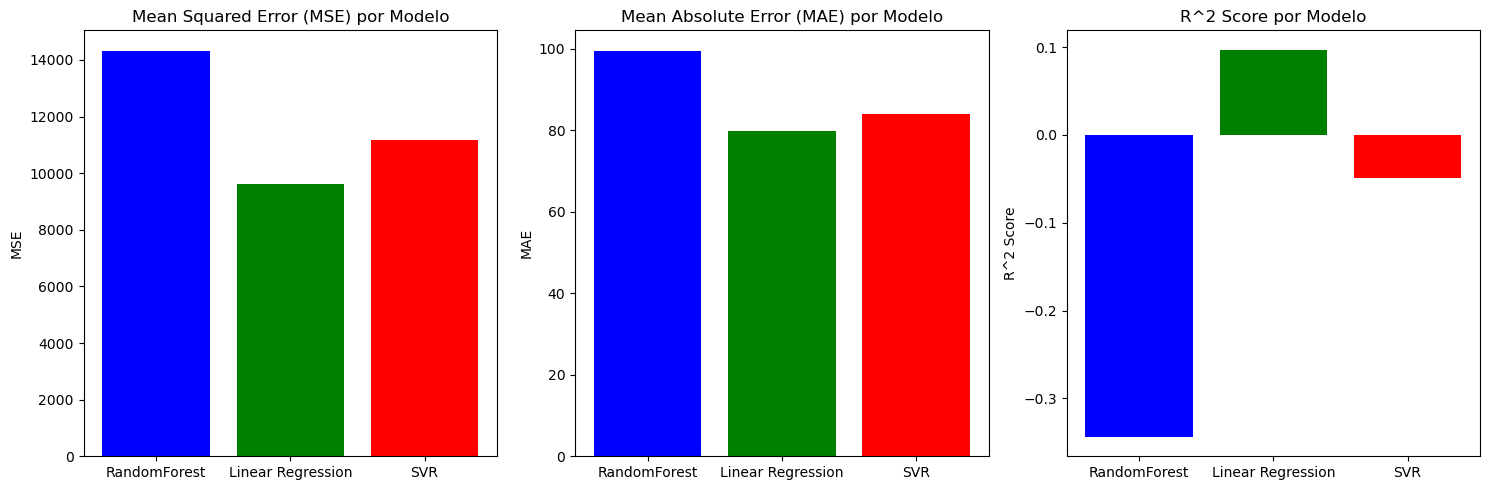

In [14]:
# Visualización de resultados
model_names = ['RandomForest', 'Linear Regression', 'SVR']
mse_values = [mse_rf, mse_lr, mse_svr]
mae_values = [mae_rf, mae_lr, mae_svr]
r2_values = [r2_rf, r2_lr, r2_svr]

plt.figure(figsize=(15, 5))

# Gráfico de MSE
plt.subplot(1, 3, 1)
plt.bar(model_names, mse_values, color=['blue', 'green', 'red'])
plt.title('Mean Squared Error (MSE) por Modelo')
plt.ylabel('MSE')

# Gráfico de MAE
plt.subplot(1, 3, 2)
plt.bar(model_names, mae_values, color=['blue', 'green', 'red'])
plt.title('Mean Absolute Error (MAE) por Modelo')
plt.ylabel('MAE')

# Gráfico de R^2 Score
plt.subplot(1, 3, 3)
plt.bar(model_names, r2_values, color=['blue', 'green', 'red'])
plt.title('R^2 Score por Modelo')
plt.ylabel('R^2 Score')

plt.tight_layout()
plt.show()